<a href="https://colab.research.google.com/github/sylv0303/Git/blob/main/Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from scipy.stats import norm
from math import sqrt
import yfinance as yf
# !pip install yahoo_fin
from yahoo_fin import options as op

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Implied Volatility
En termes simples, la volatilité implicite nous dit ce que le marché pense des fluctuations actuelles et futures des prix. C'est comme une prévision des changements futurs, et c'est pourquoi il est crucial
pour nous d'évaluer et de gérer les risques.
La volatilité implicite est dérivée en insérant le prix du marché de l'option dans la formule Black-Scholes et en faisant de l'ingénierie inverse pour déterminer la valeur de la volatilité. Cependant, il existe différentes méthodes pour calculer la volatilité implicite, telles que l'exemple ci-dessous où nous avons utilisé la méthode de Newton pour la solution numérique.

En termes simples, la formule Black-Scholes est utilisée pour
estimer la valeur des options financières. Cela nous aide à
comprendre comment le prix d'une option peut changer en fonction
de divers facteurs, ce qui en fait un outil précieux pour la
tarification des options et les décisions de négociation.
Maintenant que nous comprenons l'importance de la volatilité
implicite et le rôle de l'équation de Black-Scholes dans la dérivation
de sa valeur, la question suivante est la suivante : comment
calculons-nous la volatilité implicite ?
Exactement ! Lorsque vous pensez au calcul de la volatilité
implicite, le processus dont nous avons discuté plus tôt me vient
naturellement à l'esprit, n'est-ce pas ? C'est parce que c'est non
seulement le moyen principal, mais aussi le plus efficace de dériver
la volatilité implicite. Voici une fonction qui fait le travail.



1) Black & Scholes Model

In [2]:
def CallPrice (S, sigma, K, T, r):
  d1 = (np.log(S / K) + (r  + 0.5 * sigma**2/2) * T) / (sigma * sqrt(T))
  d2 = d1 - sigma * sqrt(T)
  price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

  return price

In [3]:
# Parameters
S = 100
K = 105
T = 0.5
r = 0.02
vol = 0.2

print(np.round(CallPrice(S, vol, K, T, r), 3))

3.982


## Newton-Raphson Algorithm
We will calculate the implied volatility given the option prices calculated with the Black & Scholes (B&S) model (data).
For this, we will use Newton's method with root finding. We want to resolve:

$$
\text{Call}_{\text{BS}}(\sigma_{\text{implied}}) = P \iff f(x) = \text{Call}_{\text{BS}}(x) - P
$$


We use the 1st order Taylor expansion:

$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$

We fix a tolerance level and iterate the algorithm until the difference between the two consecutive estimations is below this level.

In [4]:
def newton_step(f, x0):
  def df(x):
    dx = 0.00001
    return (f(x + dx) - f(x)) / dx # calcul de la derivée (formule) --> donne une approximation
  return x0 - f(x0)/df(x0) # on utilise l'approximation de cette dérivée pour calculer x1

def newton(f, x0, tol):
    while abs(newton_step(f, x0) - x0) > tol: # on itère jusqu'à ce que la diffèrence entre l'approximation n+1 et n soit en dessous du seuil de tolerance
        x0 = newton_step(f, x0)
    return x0


## Implied volatility estimation
$$ f(x) = \text{Call}_{\text{BS}}(x) - P
$$

In [5]:
#CallPrice(vol) - TargetPrice
CallPriceVol = lambda vol: CallPrice(S, vol, K, T, r) - C  # pour trouver quand f(x) = 0 (intersection des abscisses) --> on trouve la racine x (vol implicite) donc f(x)= prix de l'option observé sur le marché

In [6]:
C = CallPrice(S, vol, K, T, r)
init = 0.1  # on initialise x0
tol = 10**-8   # on rensiegne la tolérance (quand on s'arrête)
print(newton(CallPriceVol, init, tol)) # on fait fonctionner l'algo et ça nous renvoie la vol implicite

0.20000000002855028


In [7]:
# On teste 4 itérations de l'algo, on aura x0, x1, x2, x3 et x4 (vol implicite)
x0 = init
for i in range(0,4):
  print(x0)
  x0 = newton_step(CallPriceVol, x0)

0.1
0.20770294364521646
0.20000902556434494
0.20000000002855028


## Inflexion Point

We could use the 2nd order Taylor expansion to estimate the implied volaticity:

$$
f(x) = f(x_n) + f'(x_n)(x-x_n) + \frac{f''(\epsilon_n)}{2}(x-x_n)^2
$$

with

$$
x = x_{\text{target}} \quad \text{and} \quad f(x_{\text{target}}) = 0
$$

$$
x_{\text{target}} = x_n - \frac{f(x_n)}{f'(x_n)} - \frac{f''(x_n)}{2f'(x_n)}(x_{\text{target}} - x_n)^2
$$

One of the drawbacks of the Newton-Raphson Method is that convergence is not guaranteed.

We want to optimize the Newton-Raphson algorithm and to do this, we start the algorithm at an inflection point. Indeed, we know that at the inflection point, the second derivative is equal to zero because the curve is convex to the left and concave to the right. Therefore, our series σn is monotonous with:

$$
\sigma_0 > \sigma_1 > \sigma_2 > \ldots > \sigma_{\text{implied}}
$$

The algorithm is convergent and optimized.

The value of the inflection point is given by :

$$
I = \sqrt{\frac{2 \cdot |\log(m)|}{T}} \quad \text{and} \quad m = \frac{S}{K \cdot e^{-rT}} \quad \text{(moneyness)}
$$

In [8]:
def Inflexionpoint (S, K, T, r):
  m = S / (K * np.exp(-r * T))
  return np.sqrt(2 * np.abs(np.log(m)) / T)

In [9]:
I = Inflexionpoint(S, K, T, r)
print("Inflexion Point:",I)

Inflexion Point: 0.39390437504263387


## Implied Volatility for Call Option

$$ f(x) = \text{Call}_{\text{BS}}(x) - P
$$
This equation can be solved with the Newton-Raphson algorithm, using the inflection point as the initial guess. The series σn is monotonous:

$$
\sigma_0 = I, \quad \sigma_{n+1} = \sigma_n - \frac{\text{Call}_{\text{BS}}(\sigma_n) - P}{\frac{\partial \text{Call}_{\text{BS}}(\sigma_n)}{\partial \sigma}}
$$

where Vega is:

$$
\frac{\partial \text{Call}_{\text{BS}}(\sigma_n)}{\partial \sigma} = S \cdot \sqrt{T} \cdot N'(d_1)
$$

In [10]:
def vega(S, sigma, K, T, r):
  d1 = (np.log(S / K) + (r  + 0.5 * sigma**2/2) * T) / (sigma * sqrt(T))
  vega = S * T**0.5 * norm.cdf(d1)
  return vega

def ImpliedVolCall(C, S, K, r, T, tol):
  x0 = Inflexionpoint(S, K, T, r)
  p = CallPrice(S, x0, K, T, r)
  v = vega(S, x0, K, T, r)
  while (abs((p - C) / v) > tol):
    x0 = x0 - (p - C) / v
    p = CallPrice(S, x0, K, T, r)
    v = vega(S, x0, K, T, r)
  return x0

In [11]:
# Parameters
S = 100
K = 105
T = 0.5
r = 0.02
vol = 0.2

C = CallPrice(S, vol, K, T, r)

In [12]:
tol = 10**-8
ImpliedVolCall(C, S, K, r, T, tol)

0.2000000053694155

## 3) Import options data


In [65]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

# Set stock ticker and expiry date
ticker = input("Enter stock ticker: ")
expiry = input("Enter expiry date: ")

# Get stock data for the past year
start_date = pd.to_datetime('today') - pd.DateOffset(years=1)
end_date = pd.to_datetime('today')
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate historical volatility
returns = stock_data['Adj Close'].pct_change().dropna()
volatility = returns.std() * np.sqrt(252)

# Get option chain for stock ticker and expiry date
option_chain = yf.Ticker(ticker).option_chain(expiry)

# Filter option chain for puts and calls
puts = option_chain.puts.sort_values(by='lastPrice')
calls = option_chain.calls.sort_values(by='lastPrice')

# Filter for conservative trader
conservative_puts = puts[puts["inTheMoney"] == True].head(5)
conservative_calls = calls[calls["inTheMoney"] == True].tail(5)

# Set risk-free interest rate
r = -0.0626

# Calculate time to expiration in years
t = (pd.to_datetime(expiry) - pd.to_datetime('today')).days / 365

Enter stock ticker: 'AAPL'
Enter expiry date: 2024-02-02


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:["'AAPL'"]: Exception("%ticker%: No timezone found, symbol may be delisted")


ValueError: Expiration `2024-02-02` cannot be found. Available expirations are: []

In [66]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

# Set stock ticker and expiry date
ticker = 'AAPL'
expiry = op.get_expiration_dates(ticker)

# Get stock data for the past year
start_date = pd.to_datetime('today') - pd.DateOffset(years=1)
end_date = pd.to_datetime('today')
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate historical volatility
returns = stock_data['Adj Close'].pct_change().dropna()
volatility = returns.std() * np.sqrt(252)

# Get option chain for stock ticker and expiry date
option_chain = op.get_options_chain(ticker, date = expiry[0])

# Filter option chain for puts and calls
calls = op.get_calls(ticker, date = expiry[0]).sort_values(by='Last Price')
puts = op.get_puts(ticker, date = expiry[0]).sort_values(by='Last Price')
# # Filter for conservative trader
# conservative_puts = puts[puts["inTheMoney"] == True].head(5)
# conservative_calls = calls[calls["inTheMoney"] == True].tail(5)

# Set risk-free interest rate
r = -0.0626

# Calculate time to expiration in years
t = (pd.to_datetime(expiry) - pd.to_datetime('today')).days / 365

[*********************100%%**********************]  1 of 1 completed


In [61]:
ticker = 'AAPL'

# Get expiration dates
expirationDates = op.get_expiration_dates(ticker)
expirationDates

['February 16, 2024',
 'February 23, 2024',
 'March 1, 2024',
 'March 8, 2024',
 'March 15, 2024',
 'March 22, 2024',
 'April 19, 2024',
 'May 17, 2024',
 'June 21, 2024',
 'July 19, 2024',
 'August 16, 2024',
 'September 20, 2024',
 'December 20, 2024',
 'January 17, 2025',
 'March 21, 2025',
 'June 20, 2025',
 'September 19, 2025',
 'December 19, 2025',
 'January 16, 2026',
 'June 18, 2026']

In [64]:
# Call and Put option data
callData = op.get_calls(ticker, date = expirationDates[0])
putData = op.get_puts(ticker, date = expirationDates[0])

# Chain data
chainData = op.get_options_chain(ticker, date = expirationDates[0])
callData

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,AAPL240216C00050000,2024-02-09 12:55PM EST,50.0,139.55,138.50,139.15,1.6,+1.16%,2,2,476.56%
1,AAPL240216C00055000,2024-01-23 12:57PM EST,55.0,140.25,133.60,134.25,0.0,-,1,0,373.44%
2,AAPL240216C00060000,2024-01-30 2:04PM EST,60.0,127.80,128.65,129.25,0.0,-,2,0,359.38%
3,AAPL240216C00065000,2024-01-04 3:52PM EST,65.0,117.06,120.50,121.35,0.0,-,1,1,0.00%
4,AAPL240216C00070000,2024-02-02 11:12AM EST,70.0,116.53,118.20,119.60,0.0,-,5,1,290.63%
...,...,...,...,...,...,...,...,...,...,...,...
64,AAPL240216C00300000,2023-10-24 2:28PM EST,300.0,0.01,0.00,0.02,0.0,-,4,76,117.19%
65,AAPL240216C00305000,2024-02-06 1:38PM EST,305.0,0.01,0.00,0.01,0.0,-,3,254,112.50%
66,AAPL240216C00310000,2024-01-23 9:49AM EST,310.0,0.01,0.00,0.01,0.0,-,10,235,118.75%
67,AAPL240216C00315000,2023-09-15 12:36PM EST,315.0,0.03,0.00,0.03,0.0,-,23,285,132.81%


### Clean data
We use only liquid options. We eliminate options with a volume inferior to 1000. Options ITM or OTM are little liquid, we exclude them



## 4) Select relatively liquid options to compare our results with data

In [63]:
treshold_volume = 50 # on exclut les options avec un volume faible car peu liquides, les options OTM ou ITM sont souvent moins liquides que celles près de la monnaie (ATM)

callData["Volume"] = pd.to_numeric(callData["Volume"])
call_filter = callData[
    (callData["Volume"] >= treshold_volume)
]
call_filter.head(5)

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
12,AAPL240216C00110000,2024-02-08 2:23PM EST,110.0,78.10,78.40,79.45,0.00,-,202,1,172.27%
14,AAPL240216C00120000,2024-02-08 2:23PM EST,120.0,68.10,68.40,69.40,0.00,-,100,3,139.84%
17,AAPL240216C00135000,2024-02-08 3:37PM EST,135.0,53.19,53.75,54.40,0.00,-,87,0,130.66%
20,AAPL240216C00150000,2024-02-09 3:55PM EST,150.0,39.03,38.85,39.20,0.81,+2.12%,114,96,90.63%
23,AAPL240216C00160000,2024-02-09 3:13PM EST,160.0,28.88,28.80,29.20,0.83,+2.96%,104,4325,66.80%


In [25]:
# Remplacer les valeurs "-" par NaN
putData = putData.replace("-", float('nan'), regex=True)

# Convertir les données en nombre
putData['Strike'] = pd.to_numeric(putData['Strike'], errors='coerce')
putData['Last Price'] = pd.to_numeric(putData['Last Price'], errors='coerce')


putData["Volume"] = pd.to_numeric(putData["Volume"])
put_filter = putData[
    (putData["Volume"] >= treshold_volume)
]
put_filter.head(5)

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
6,AAPL240216P00080000,NaN,80.0,0.01,0.0,0.01,0.0,NaN,2907.0,3088,206.25%
12,AAPL240216P00110000,NaN,110.0,0.01,0.0,0.01,0.0,NaN,1944.0,2101,131.25%
13,AAPL240216P00115000,NaN,115.0,0.01,0.0,0.01,0.0,NaN,86.0,2961,121.88%
14,AAPL240216P00120000,NaN,120.0,0.01,0.0,0.01,0.0,NaN,184.0,3603,112.50%
15,AAPL240216P00125000,NaN,125.0,0.01,0.0,0.01,0.0,NaN,790.0,3637,103.13%


## 5) View the implied volatilities contained in the dataframe for the same maturity


### 5.1) Call option

####a) Expire In-The-Money (ITM)
Lorsqu'une option expire dans l'argent (ITM), cela signifie que
l'option a fini par être rentable.
La rentabilité à l'expiration est la probabilité que l'option se termine
dans l'argent (ITM). Ceci est calculé à l'aide du modèle BlackScholes-Merton, une méthode mathématique courante pour fixer le
prix des options de style européen.
Maintenant, considérez l'équation mathématique pour la
distribution de probabilité :
$$ Probabilité = CDF(d1) $$

Où :
• d1 fait partie de la formule Black-Scholes.
• Le CDF est la fonction de distribution cumulative de la
distribution normale standard.
En termes plus simples, nous calculons la probabilité en regardant
la fonction de distribution normale standard à un point particulier
(déterminée par d1). Plus la probabilité est élevée, plus nous nous
attendons à ce que l'option soit rentable à l'expiration. Il est
essentiel de noter que cette probabilité n'est pas une probabilité
statistique de profit, mais plutôt une mesure dérivée des modèles de
tarification des options.
Nous calculons la probabilité en définissant une fonction comme cidessous :

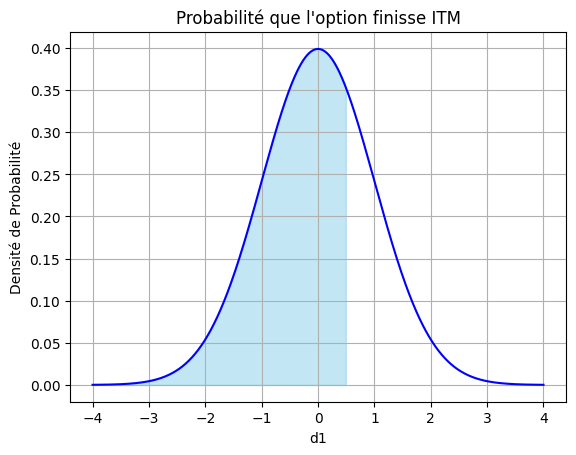

Probabilité que l'option finisse ITM: 0.6914624612740131


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def itm_probability(d1):
    return norm.cdf(d1)

def plot_itm_probability(d1):
    x = np.linspace(-4, 4, 1000)
    y = norm.pdf(x)
    plt.plot(x, y, 'b')
    plt.fill_between(x, y, where=(x <= d1), color='skyblue', alpha=0.5)
    plt.title("Probabilité que l'option finisse ITM")
    plt.xlabel('d1')
    plt.ylabel('Densité de Probabilité')
    plt.grid(True)
    plt.gca().set_facecolor('none')  # Fond transparent
    plt.show()

# Valeur de d1
d1 = 0.5

# Tracé de la probabilité que l'option finisse ITM avec l'aire sous la courbe et fond transparent
plot_itm_probability(d1)
print("Probabilité que l'option finisse ITM:", probability)

In [16]:
def calculate_probability(option_data) :
  S = option_data["underlier_price"]
  K = option_data["Strike"]
  r = option_data["discount_rate"]
  sigma = option_data["Implied Volatility"]
  T = option_data["years_to_expiration"]
  d1 = (math.log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * math.sqrt(T))
  probability = norm.cdf(d1)

  return probability

IndentationError: expected an indented block after function definition on line 1 (<ipython-input-16-a7df68adec56>, line 2)

####b) Bid-Ask spread
L'écart Bid-Ask est la différence entre le prix le plus élevé qu'un
acheteur est prêt à payer (Bid) et le prix le plus bas qu'un vendeur
est prêt à accepter (Ask) pour un titre. Il sert d'indicateur de la
liquidité du marché, des coûts de transaction et de l'équilibre entre
l'offre et la demande. Un écart étroit indique un marché liquide avec
des coûts de transaction plus faibles, tandis qu'un écart plus large
peut suggérer une liquidité réduite ou une incertitude accrue du
marché.
Les traders tiennent souvent compte de l'écart Bid-Ask lorsqu'ils
prennent des décisions, dans le but de minimiser les coûts et de
naviguer efficacement dans les conditions du marché. Les teneurs
de marché profitent de cette propagation en facilitant les échanges
entre acheteurs et vendeurs.
Pour calculer l'écart Bid-Ask, nous définissons une fonction comme
suit :

In [15]:
def bid_ask_spread_analysis(option_data):
  bid_ask_spread = option_data["Bid"] - option_data["Ask"]
  return bid_ask_spread

####c) Compilation of all tools
Maintenant, pour notre dernière étape, nous calculons l'ensemble
complet de mesures en utilisant les fonctions précédemment
définies. Cela implique de calculer la volatilité implicite,
l'expiration dans la monnaie (ITM) et l'écart Bid-Ask, ce qui
nous fournit une évaluation complète des caractéristiques et de la
rentabilité potentielle de l'option. Cette approche à multiples
facettes nous permet de prendre des décisions éclairées et d'obtenir
des informations précieuses sur la dynamique de l'option spécifique
envisagée :

In [ ]:
# Calculate probability
option_data["probability"] = calculate_probability(option_data)

# Bid-Ask spread analysis
option_data["bid_ask_spread"] = bid_ask_spread_analysis(option_data)

print("Implied Volatily:", option_data["implied_volatility"])
print("Probability:", option_data["probability"])
print("Bid-Ask Spread:", option_data["bid_ask_spread"])

#### d) Single function

In [ ]:
def calculate_metrics(option_data) :
  result = {}

  S = option_data["underlier_price"]
  K = option_data["Strike"]
  r = option_data["discount_rate"]
  sigma = option_data["Implied Volatility"]
  T = option_data["years_to_expiration"]

  d1 = (math.log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * math.sqrt(T))
  probability = norm.cdf(d1)

  bid_ask_spread = (option_data["Bid"] - option_data["Ask"]) / 2

  result["implied_volatility"] = option_data["Implied Volatility"]
  result["probability"] = probability
  result["bid_ask_spread"] = bid_ask_spread_analysis(option_data)

  return result

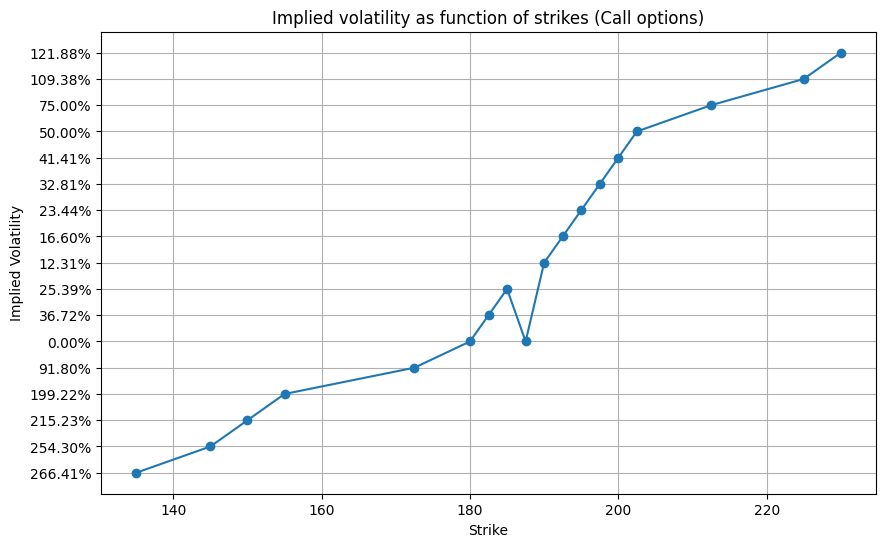

In [ ]:
implied_volatility_call = call_filter["Implied Volatility"]
strike_call = call_filter["Strike"]

plt.figure(figsize=(10, 6))
plt.plot(strike_call, implied_volatility_call, marker='o', linestyle='-')
plt.title("Implied volatility as function of strikes (Call options)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()


# Smile volatility
As the strike price K increases for call options, implied volatility increases. This is generally observed for OTM (Out-of-The-Money) options, as there is a lower probability of the option ending in the money, making these options riskier and more expensive.

Conversely, when the strike price falls for a call, implied volatility tends to fall. This is partly because ITM options are often more widely traded and liquid, which reduces the option premium and hence implied volatility.

### 5.2) Put Option

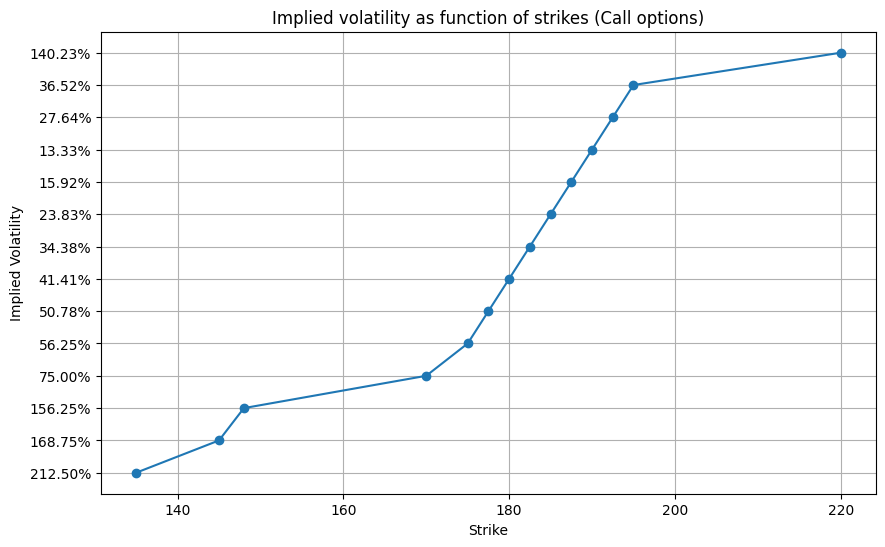

In [ ]:
strike_put = put_filter["Strike"]
implied_volatility_put = put_filter["Implied Volatility"]

plt.figure(figsize=(10,6))
plt.plot(strike_put, implied_volatility_put, marker='o', linestyle='-')
plt.title("Implied volatility as function of strikes (Call options)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

## 6) Calculate implied volatility with our functions

In [ ]:
S = 100
T = callData['Last Trade']  # Assurez-vous que vous avez la durée en années
r = 0.05
target_price = callData['lastPrice']  # Remplacez 'lastPrice' par le nom de la colonne contenant le prix de l'option observé sur le marché
tol = 10**-8

ImpliedVolCall(target_price, S, K, r, T, tol)

KeyError: 'Last Trade'